# Imports

In [1]:
%matplotlib inline
# %matplotlib qt
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
from sklearn import datasets
from sklearn.neighbors import NearestNeighbors
import sklearn.neighbors._unsupervised
from draw_utils import draw_3d_clusters, draw_spiral_clusters
from matplotlib.ticker import LogFormatterExponent
plt.rcParams['figure.figsize'] = [15, 10]
%load_ext autoreload
%autoreload 2

# Load Checkpoints

In [29]:
with open('./saved/ckpt_mnist_7.pickle', 'rb') as f:
    x = pickle.load(f)
x.keys()

dict_keys(['knn', 'X', 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5])

# Preview clusters for 2d and 3d manifolds

In [30]:
k = 10
C = x[k]['C']
X = x['X']
if X[0].shape[0] == 2:
    draw_spiral_clusters(C, X, k=x['knn'])
elif X[0].shape[0] == 3:
    draw_3d_clusters(C, X)

# Compute error plot

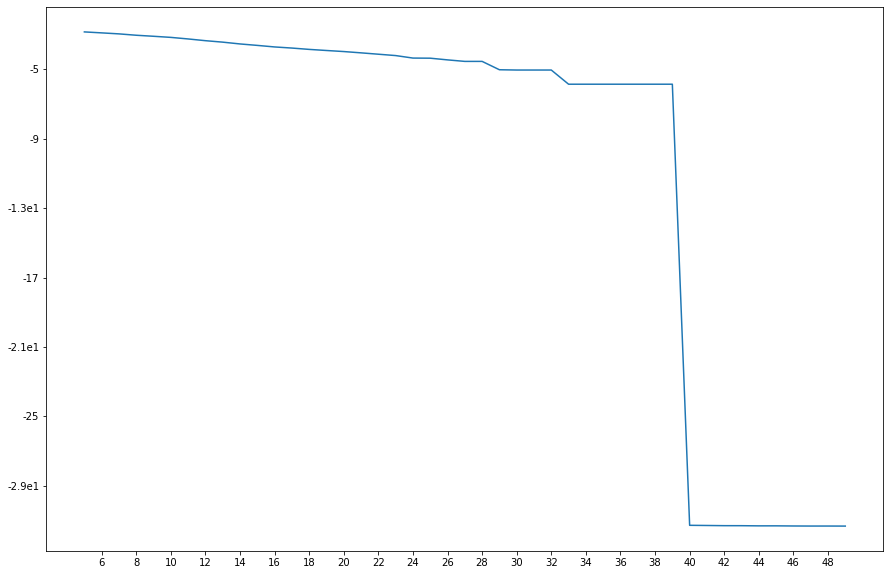

In [31]:
errors = {}
for it in x.keys():
    if it == 'knn' or it == 'X':
        continue
    
    e = []
    C = x[it]['C']
    for Ci in C:
        F = Ci.F
        P = np.dot(F, F.T)
        samples = np.array(X[Ci.indices]).T
        mean_pos = np.mean(samples, axis=1, keepdims=True)
        s = samples - mean_pos

        proj = np.dot(P, s)
        e.append((s - proj)**2)
    errors[it] = np.mean(np.concatenate(e, axis=1), axis=(0, 1))

plt.semilogy(list(errors.keys()), list(errors.values()))
ax = plt.gca()
plt.xticks(list(errors.keys())[1::2])
ax.yaxis.set_major_formatter(LogFormatterExponent())
plt.show()

# Preview BSDS reconstruction

In [148]:
k = 90  # Number of clusters in checkpoint to use for reconstruction
proj = []
samples = []

C = x[k]['C']
for Ci in C:
    F = Ci.F
    P = np.dot(F, F.T)
    samp = np.array(Ci.X).T
    mean_pos = np.mean(samp, axis=1, keepdims=True)
    s = samp - mean_pos

    samples.extend(samp.T)
    proj.extend((np.dot(P, s) + mean_pos).T)
    
proj = np.concatenate(proj, axis=0)
samples = np.concatenate(samples, axis=0)
proj.shape, samples.shape

((501592,), (501592,))

In [134]:
ith = 2000
s = samples[:, ith].reshape((8, 8))
p = proj[:, ith].reshape((8, 8))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(s, cmap='gray')
ax2.imshow(p, cmap='gray')
ax3.imshow(np.clip(np.abs(p - s) * 255, 0, 255).astype(np.uint8), cmap='gray')

TypeError: list indices must be integers or slices, not tuple

# Preview VIDTIMIT reconstruction

In [4]:
k = 15 # Number of clusters in checkpoint to use for reconstruction
proj = []
samples = []

C = x[k]['C']
for Ci in C:
    F = Ci.F
    P = np.dot(F, F.T)
    samp = np.array(X[Ci.indices]).T
    mean_pos = np.mean(samp, axis=1, keepdims=True)
    s = samp - mean_pos
    
    samples.extend(samp.T)
    proj.extend((np.dot(P, s) + mean_pos).T)
    
proj = np.concatenate(proj, axis=0).reshape((-1, 26, 26))
samples = np.concatenate(samples, axis=0).reshape((-1, 26, 26))
proj.shape, samples.shape

((885, 26, 26), (885, 26, 26))

In [5]:
from datasets_util import load_vidtimit
subject = 1
X = load_vidtimit('../data/vidtimit/', subject=subject, skip_pickle=False)
mean = np.mean(X, axis=0).reshape((26, 26))
std = np.std(X, axis=0).reshape((26, 26))
mean.shape, std.shape

((26, 26), (26, 26))

(885, 26, 26) (885, 26, 26)


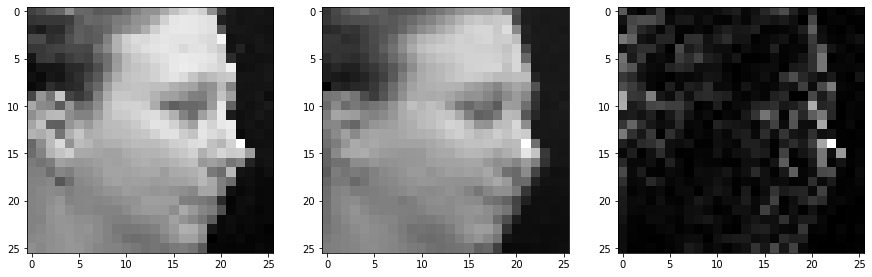

In [6]:
ith = 500
print(samples.shape, proj.shape)
s = samples[ith]
p = proj[ith]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(s * std + mean, cmap='gray')
ax2.imshow(p * std + mean, cmap='gray')
ax3.imshow(np.abs(p - s), cmap='gray')

# Clusters preview

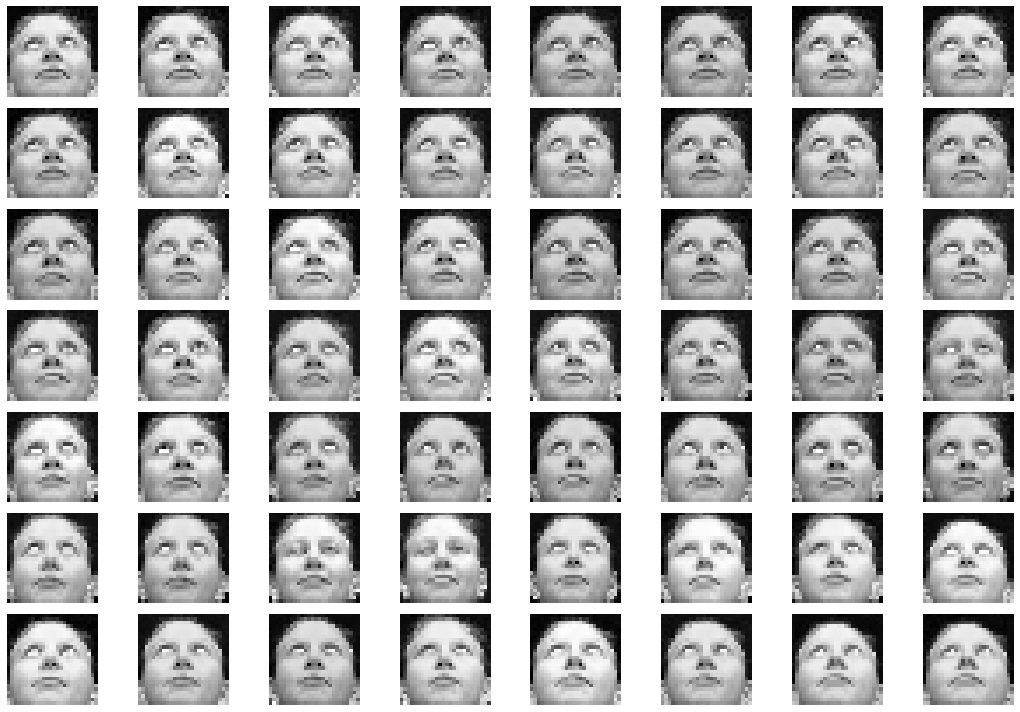

In [18]:
ith = 1
Ci = C[ith]
fig, axs = plt.subplots(nrows=int(np.sqrt(len(Ci.indices))), ncols=int(np.sqrt(len(Ci.indices)) + 1))
for i, ax in enumerate(axs.flat):
    if len(Ci.X) <= i:
        break
    ax.axis('off')
    s = Ci.X[i]
    ax.imshow((s.reshape((26, 26)) * std + mean), cmap='gray')
fig.tight_layout()

# MNIST

In [72]:
from mnist import MNIST
mndata = MNIST('../data/MNIST/')
images, labels = mndata.load_training()
images = np.array(images)
images = images / 255
labels = np.array(labels)
images.shape, labels.shape

((60000, 784), (60000,))

## GSI in original space

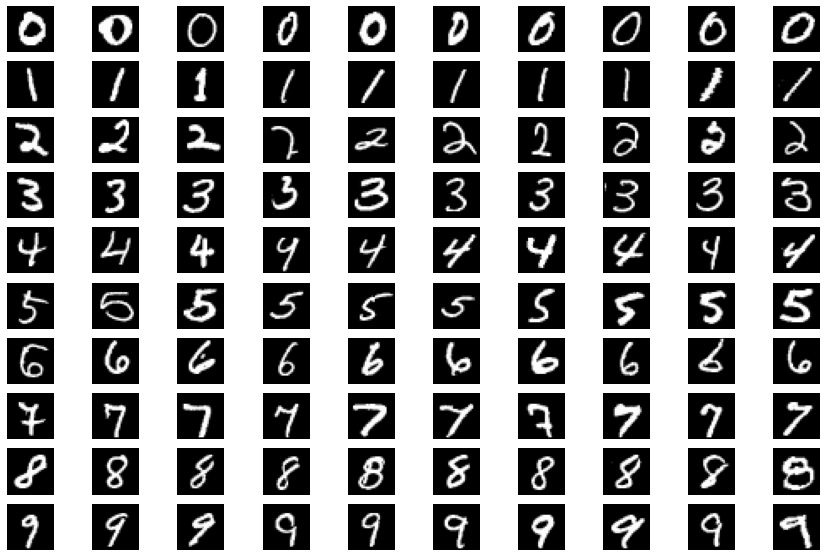

In [73]:
# Create balanced subset
s = 2000
X = np.zeros((s * 10, 784))
Y = np.zeros((s * 10))
for i in range(10):
    v = images[labels == i]
    X[s * i:s * (i + 1)] = v[np.random.choice(v.shape[0], size=s, replace=False)]
    Y[s * i:s * (i + 1)] = i
fig, axs = plt.subplots(ncols=10, nrows=10)
for ith, ax in enumerate(axs.flat):
    ax.imshow(X[s * (ith // 10) + ith % 10].reshape((28, 28)), cmap='gray')
    ax.axis('off')

In [74]:
# Compute GSI
knn = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(X)
n_idx = knn.kneighbors(X, return_distance=False)[:, 1:].squeeze(1)
GSI = np.sum(Y == Y[n_idx]) / X.shape[0]
GSI

0.96045

# Reconstruction MNIST

In [33]:
k = 20 # Number of clusters in checkpoint to use for reconstruction
proj = []
samples = []

C = x[k]['C']
for Ci in C:
    F = Ci.F
    P = np.dot(F, F.T)
    samp = np.array(X[Ci.indices]).T
    mean_pos = np.mean(samp, axis=1, keepdims=True)
    s = samp - mean_pos
    
    samples.extend(samp.T)
    proj.extend((np.dot(P, s) + mean_pos).T)
    
proj = np.concatenate(proj, axis=0).reshape((-1, 28, 28))
samples = np.concatenate(samples, axis=0).reshape((-1, 28, 28))
proj.shape, samples.shape

((2000, 28, 28), (2000, 28, 28))

(2000, 28, 28) (2000, 28, 28)


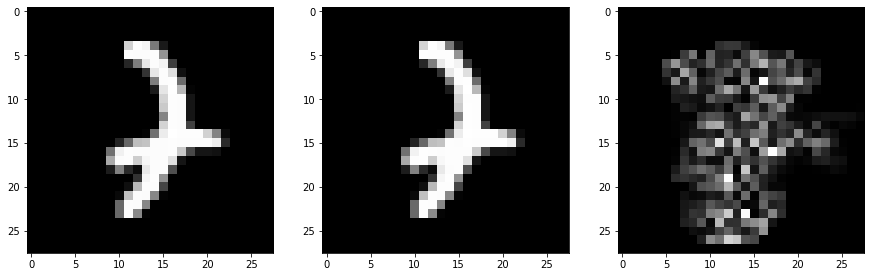

In [36]:
ith = 10
print(samples.shape, proj.shape)
s = samples[ith]
p = proj[ith]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.imshow(s * 255, cmap='gray')
ax2.imshow(p * 255, cmap='gray')
ax3.imshow(np.abs(p - s), cmap='gray')

# Clusters preview

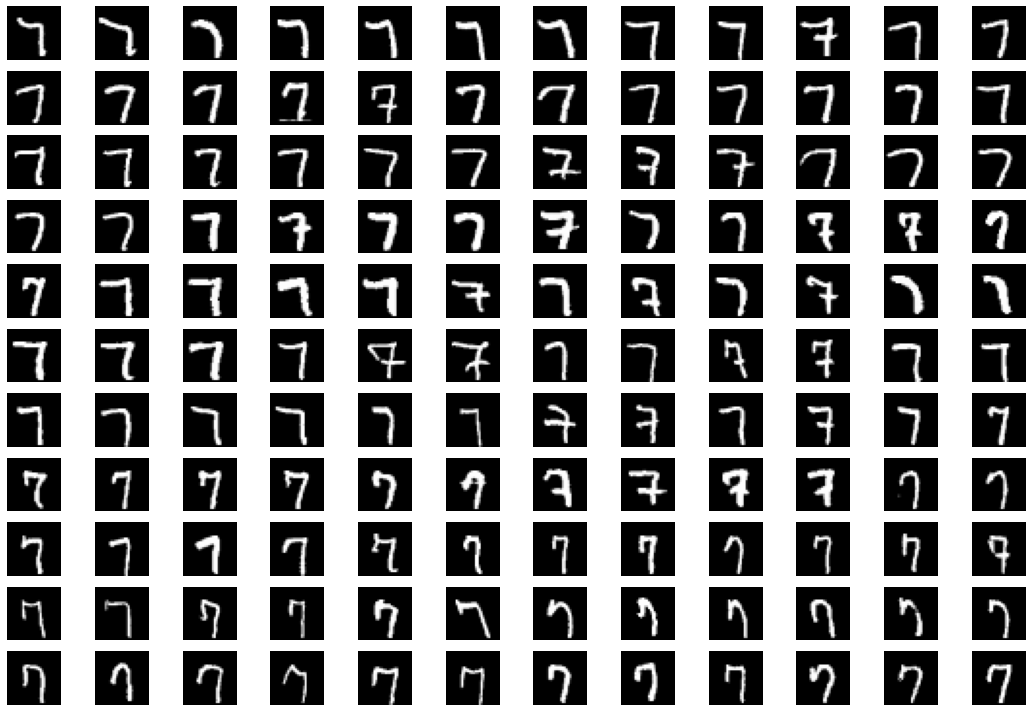

In [38]:
ith = 1
Ci = C[ith]
fig, axs = plt.subplots(nrows=int(np.sqrt(len(Ci.indices))), ncols=int(np.sqrt(len(Ci.indices)) + 1))
for i, ax in enumerate(axs.flat):
    if len(Ci) <= i:
        break
    ax.axis('off')
    s = X[Ci.indices[i]]
    ax.imshow(s.reshape((28, 28)), cmap='gray')
fig.tight_layout()

# GSI on computed flats

In [75]:
C_digits = []
Xs = []
k = 10  # Num clusters of ckpt to compute gsi

for i in range(10):
    with open('./saved/ckpt_mnist_%s.pickle' % i, 'rb') as f:
        p = pickle.load(f)
        C_digits.append(p[k]['C'])
        Xs.append(p['X'])

In [ ]:
# Compute distance matrix
d = np.zeros((X.shape[0], 10, k))  # n_samples x n_digits x flats
for x_idx, x in enumerate(X):
    if x_idx % 50 == 0:
        print('Processing sample', x_idx)
    for C_idx, C in enumerate(C_digits):
        for Ci_idx, Ci in enumerate(C):
            F = Ci.F
            P = np.dot(F, F.T)
            samp = np.array(Xs[C_idx][Ci.indices]).T
            mean_pos = np.mean(samp, axis=1, keepdims=False)
            s = x - mean_pos

            proj = np.dot(P, s)
            d[x_idx][C_idx][Ci_idx] = np.mean((s - proj) ** 2)

np.save('./saved/dist_matrix_mnist.npy', d)

Processing sample 0
Processing sample 50
Processing sample 100


In [ ]:
# if d is precomputed
d = np.load('./saved/dist_matrix_mnist.npy')

In [70]:
# Compute GSI fitting the D matrix
d_flat = d.reshape((-1, 10 * k))
knn = NearestNeighbors(n_neighbors=2, metric='euclidean').fit(d_flat)
n_idx = knn.kneighbors(d_flat, return_distance=False)[:, 1:].squeeze(1)
GSI = np.sum(Y == Y[n_idx]) / X.shape[0]
GSI

0.838